# Model: Ensemble Xception
Fine Tuned

## Warning ignored

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Import Libraries

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
import os
import cv2
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import seaborn as sns
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


## For Colab uncomment

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/Dataset/data.zip"

Streaming output truncated to the last 5000 lines.
  inflating: data/28/class-28-51.jpg  
  inflating: data/28/class-28-52.jpg  
  inflating: data/28/class-28-53.jpg  
  inflating: data/28/class-28-54.jpg  
  inflating: data/28/class-28-55.jpg  
  inflating: data/28/class-28-56.jpg  
  inflating: data/28/class-28-57.jpg  
  inflating: data/28/class-28-58.jpg  
  inflating: data/28/class-28-59.jpg  
  inflating: data/28/class-28-6.jpg  
  inflating: data/28/class-28-60.jpg  
  inflating: data/28/class-28-61.jpg  
  inflating: data/28/class-28-62.jpg  
  inflating: data/28/class-28-63.jpg  
  inflating: data/28/class-28-64.jpg  
  inflating: data/28/class-28-65.jpg  
  inflating: data/28/class-28-66.jpg  
  inflating: data/28/class-28-67.jpg  
  inflating: data/28/class-28-68.jpg  
  inflating: data/28/class-28-69.jpg  
  inflating: data/28/class-28-7.jpg  
  inflating: data/28/class-28-70.jpg  
  inflating: data/28/class-28-71.jpg  
  inflating: data/28/class-28-72.jpg  
  inflating: da

## Edit Paths

In [4]:
location = '/content/data'
no_of_classes = 38
batch_size = 32
size = 224

## Data loading

In [5]:
gpus = tf.config.list_logical_devices('GPU')
stg=tf.distribute.MirroredStrategy(gpus)

folder_dir = location
total_files = sum(len(files) for _, _, files in os.walk(folder_dir))

with tqdm(total=total_files, desc="Processing Images") as pbar:
    for folder in os.listdir(folder_dir):
        for file in os.listdir(os.path.join(folder_dir, folder)):
            image_path = os.path.join(folder_dir, folder, file)
            img = cv2.imread(image_path)
            img_resized = cv2.resize(img, (size, size))
            cv2.imwrite(image_path, img_resized)
            pbar.update(1)
picture_size = (size, size)
train_set = tf.keras.utils.image_dataset_from_directory(
    directory=folder_dir,
    shuffle=True,
    image_size=picture_size,
    batch_size=batch_size,
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=22
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    directory=folder_dir,
    shuffle=True,
    image_size=picture_size,
    batch_size=batch_size,
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=22
)

Processing Images: 100%|██████████| 11864/11864 [00:23<00:00, 506.26it/s]


Found 11864 files belonging to 38 classes.
Using 9492 files for training.
Found 11864 files belonging to 38 classes.
Using 2372 files for validation.


## Model building

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import Xception, InceptionV3, ResNet50, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Function to build a single model
def build_model(base_model, model_name):
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dense(523, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(38, activation='softmax')(x)  # Assuming 38 classes

    model = Model(inputs, outputs, name=model_name)
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Load pre-trained models
xception_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Build and compile each model separately
model_1 = build_model(xception_model, model_name='Xception_Model')
model_2 = build_model(inception_model, model_name='InceptionV3_Model')
model_3 = build_model(resnet_model, model_name='ResNet50_Model')
model_4 = build_model(efficientnet_model, model_name='EfficientNetB0_Model')

lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.1,
                                 patience=2,
                                 verbose=1)
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               verbose=1)

callbacks = [lr_scheduler, early_stopping]

## Model Train

In [9]:
# Train model 1
model_1.fit(train_set, epochs=5, validation_data=validation_set, callbacks=callbacks,
                    steps_per_epoch=len(train_set), validation_steps=len(validation_set))

# Train model 2
model_2.fit(train_set, epochs=5, validation_data=validation_set, callbacks=callbacks,
                    steps_per_epoch=len(train_set), validation_steps=len(validation_set))

# Train model 3
model_3.fit(train_set, epochs=5, validation_data=validation_set, callbacks=callbacks,
                    steps_per_epoch=len(train_set), validation_steps=len(validation_set))

# Train model 3
model_4.fit(train_set, epochs=5, validation_data=validation_set, callbacks=callbacks,
                    steps_per_epoch=len(train_set), validation_steps=len(validation_set))

Epoch 1/5
297/297 [==============================] - 202s 559ms/step - loss: 2.9105 - accuracy: 0.1533 - val_loss: 7.3396 - val_accuracy: 0.1724 - lr: 0.0010
Epoch 2/5
297/297 [==============================] - 158s 532ms/step - loss: 1.4263 - accuracy: 0.5136 - val_loss: 1.3433 - val_accuracy: 0.5881 - lr: 0.0010
Epoch 3/5
297/297 [==============================] - 158s 533ms/step - loss: 0.7017 - accuracy: 0.7684 - val_loss: 0.7996 - val_accuracy: 0.7563 - lr: 0.0010
Epoch 4/5
297/297 [==============================] - 158s 532ms/step - loss: 0.4375 - accuracy: 0.8660 - val_loss: 0.6512 - val_accuracy: 0.8339 - lr: 0.0010
Epoch 5/5
297/297 [==============================] - 158s 532ms/step - loss: 0.3139 - accuracy: 0.9048 - val_loss: 0.6598 - val_accuracy: 0.8234 - lr: 0.0010
Epoch 1/5
297/297 [==============================] - 128s 287ms/step - loss: 3.3029 - accuracy: 0.0947 - val_loss: 3.5444 - val_accuracy: 0.1248 - lr: 0.0010
Epoch 2/5
297/297 [==============================] -

## Evaluation

In [10]:
ensemble_predictions = []
num_models = 3
test_data_dir = location
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=picture_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
# Generate predictions for each model and collect them in a list
for model in [model_1, model_2, model_3, model_4]:
    predictions = model.predict_generator(test_generator)
    ensemble_predictions.append(predictions)

# Compute the average predictions of the ensemble
ensemble_predictions = np.mean(ensemble_predictions, axis=0)

# Calculate the accuracy of the ensemble predictions
ensemble_acc = np.mean(np.argmax(ensemble_predictions, axis=1) == test_generator.classes)

print('Ensemble accuracy:', ensemble_acc)

Found 11864 images belonging to 38 classes.
Ensemble accuracy: 0.9551584625758598


Model Accuracy: 86.91%
371/371 [==============================] - 51s 139ms/step
Model Accuracy: 82.09%
371/371 [==============================] - 27s 73ms/step
Model Accuracy: 2.98%
371/371 [==============================] - 40s 107ms/step
Model Accuracy: 92.28%
371/371 [==============================] - 24s 65ms/step
Ensemble Model Accuracy: 0.9551584625758598
Ensemble Model Loss: 1.2250885143876076


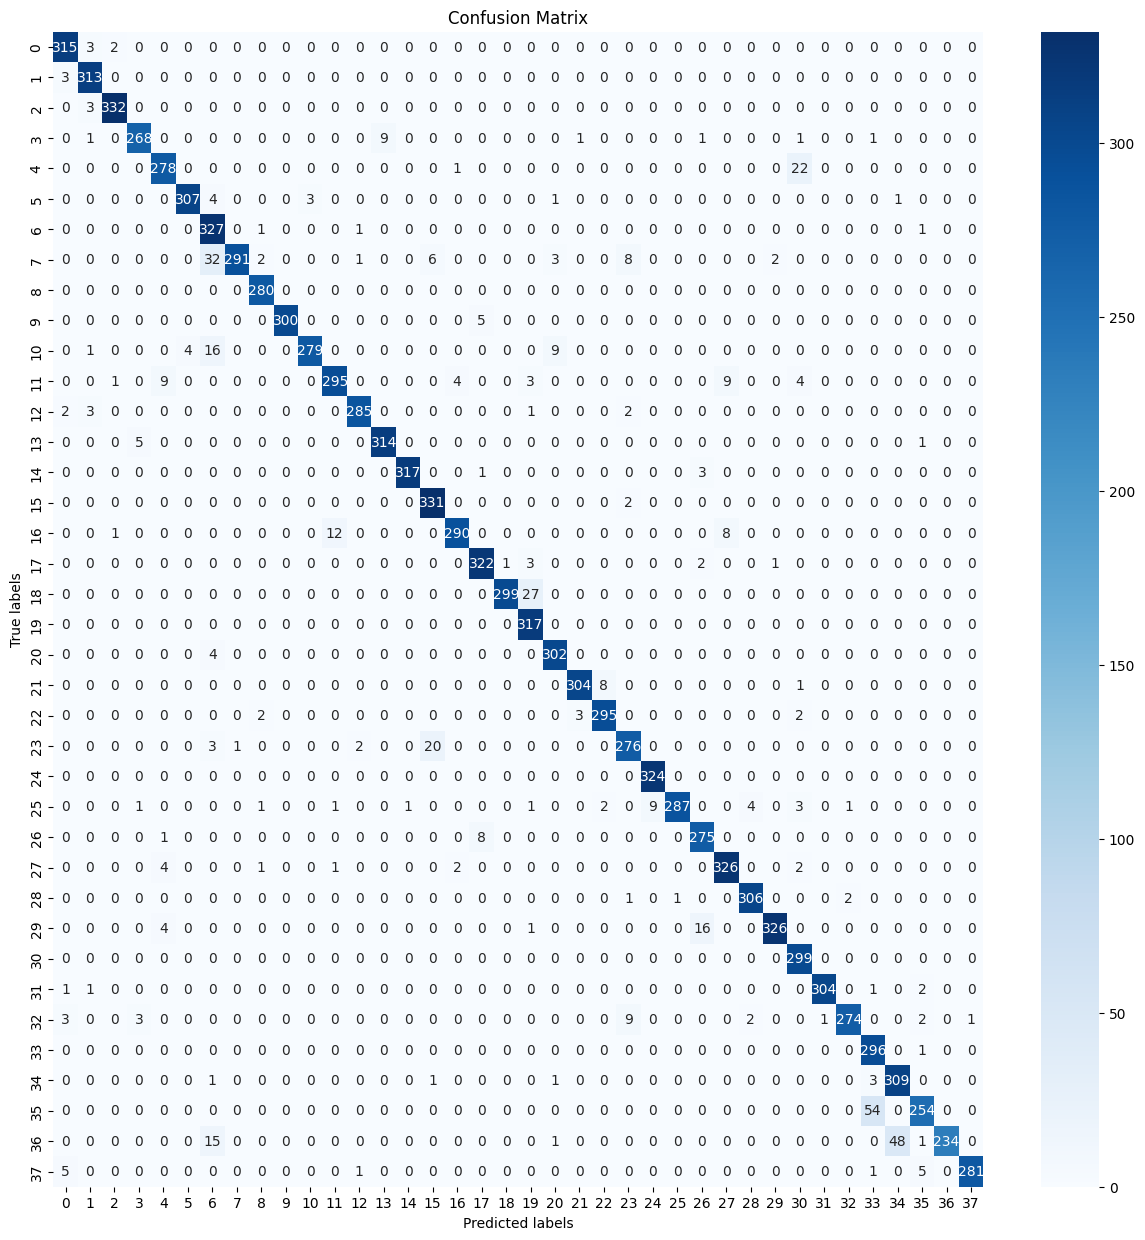

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       320
           1       0.96      0.99      0.98       316
           2       0.99      0.99      0.99       335
           3       0.97      0.95      0.96       282
           4       0.94      0.92      0.93       301
           5       0.99      0.97      0.98       316
           6       0.81      0.99      0.89       330
           7       1.00      0.84      0.91       345
           8       0.98      1.00      0.99       280
           9       1.00      0.98      0.99       305
          10       0.99      0.90      0.94       309
          11       0.95      0.91      0.93       325
          12       0.98      0.97      0.98       293
          13       0.97      0.98      0.98       320
          14       1.00      0.99      0.99       321
          15       0.92      0.99      0.96       333
          16       0.98      0.93      0.95       311
    

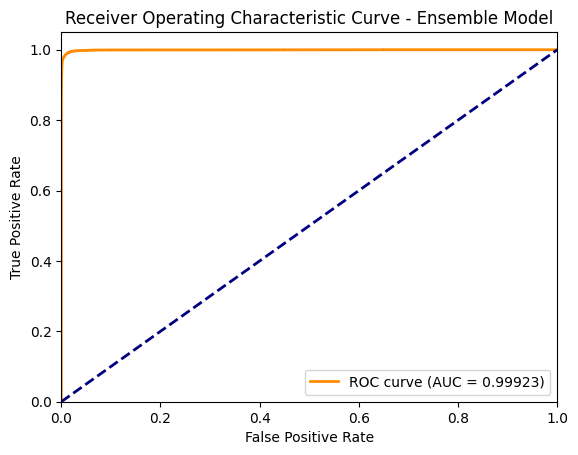

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, accuracy_score
import numpy as np
import tensorflow as tf

# Assuming you have multiple models in a list
models = [model_1, model_2, model_3, model_4]  # Replace with your actual model variables
# Evaluate each model on the test set and average their predictions
ensemble_predictions = None
test_loss = 0

for model in models:
    model_loss, model_acc = model.evaluate(test_generator, verbose=0)
    print(f'Model Accuracy: {model_acc * 100:.2f}%')

    # Summing losses for the ensemble
    test_loss += model_loss

    predictions = model.predict(test_generator)
    if ensemble_predictions is None:
        ensemble_predictions = predictions
    else:
        ensemble_predictions += predictions

# Average the predictions
ensemble_predictions /= len(models)
test_loss /= len(models)

# Evaluate the ensemble model
y_true = test_generator.classes
y_pred = np.argmax(ensemble_predictions, axis=1)

# Calculate accuracy score
accuracy = accuracy_score(y_true, y_pred)
print("Ensemble Model Accuracy:", accuracy)

# Print average loss for the ensemble
print("Ensemble Model Loss:", test_loss)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Calculate overall ROC AUC score
roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_true), ensemble_predictions, average='macro')
print("Overall ROC AUC Score:", roc_auc)

# Plot ROC curve
fpr, tpr, _ = roc_curve(tf.keras.utils.to_categorical(y_true).ravel(), ensemble_predictions.ravel())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve - Ensemble Model')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Assuming ensemble_predictions and test_generator.classes are correctly defined
# ensemble_predictions should be a numpy array of shape (num_samples, num_classes)
# test_generator.classes should be the true labels of the test set

# Generate classification report
report = classification_report(test_generator.classes, np.argmax(ensemble_predictions, axis=1),
                               target_names=test_generator.class_indices.keys())

print('Classification Report:')
print(report)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score

# Assuming ensemble_predictions and test_generator.classes are correctly defined
# ensemble_predictions should be a numpy array of shape (num_samples, num_classes)
# test_generator.classes should be the true labels of the test set

# Convert true labels to binary format
lb = LabelBinarizer()
true_labels = lb.fit_transform(test_generator.classes)

# Compute ROC curve for all classes combined
fpr, tpr, _ = roc_curve(true_labels.ravel(), ensemble_predictions.ravel())

# Calculate ROC-AUC score for all classes combined
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overall Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print ROC-AUC score
print(f'Overall ROC-AUC Score: {roc_auc:.2f}')